# Keras version of Alexnet

We'll train Alexnet with the MNIST dataset.

[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) was first introduced in 2012 and ushered in the recent resurgence of deep neural networks.  It won the 2012 ImageNet competition by a score that was significantly better than any previous model. Two year later, every state-of-the-art computer imaging model was using neural networks.

The 3 tricks of AlexNet:
1. "Deep" : Up until then it was difficult to train neural networks with many hidden layers due to the vanishing gradient and slow computer processors. AlexNet made use of GPU processors to train the network faster.
2. ReLU : AlexNet introduced the rectified linear unit (ReLU) activation function. This virtually eliminated the vanishing gradient problem.
3. Dropout : AlexNet introduced the concept of dropout. Neurons were randomly removed from the network during a batch. This helped to prevent overfitting on the training dataset.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tonyreina/keras_tutorials/blob/master/lesson_3_alexnet.ipynb)

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# Common terms

+ SGD : Stochastic gradient descent. The usual way to train a neural network. The "weights" or "parameters" of the network are updated bit by bit in order to minimize some global function ("cost" or "loss")
+ "Cost" or " Loss" - A function we wish the network to minimize. This is typically some distance measure of how far the network's prediction is from the actual value (i.e. the error).
+ Epoch = A single pass through the entire training set. SGD involves mulitple passes through the training dataset. 
+ Batch = How many samples of the training dataset are used to create an update to the weights of the network during SGD. If the batch is 1, then the weights are updated after every forward pass (truly stochastic descent). If the batch is the size of the dataset then the weights are updated based on the sum of the gradients for the entire training set (non-stochastic or just gradient descent). We usually use batch or mini-batch gradient descent.

In [2]:
batch_size = 128
num_classes = 10
epochs = 4

# MNIST

This is the standard dataset of handwritten digit classification. The images are 28 pixels by 28 pixels. There is only 1 color channel (grayscale). For color images there are typically 3 color channels (red, blue, green).

Tensor size = NHWC = Batch size x 28 x 28 x 1

In [3]:
# input image dimensions
img_rows, img_cols, n_channels = 28, 28, 1
input_shape = (img_rows, img_cols, n_channels)

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_channels)

In [5]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= x_train.max()  # Scale everything between 0 and 1
x_test /= x_test.max()  # Scale everything between 0 and 1

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# One Hot Encoding

For multi-class problems we always one-hot encode the output variable. There are 10 classes (numbers 0-9). The label for 7 would be 0000001000. The label for 0 would be 1000000000. The label for 3 would be 0010000000. This allows us to use the cost function of [multi-class entropy](https://en.wikipedia.org/wiki/Cross_entropy) which will maximize the margin between classes.

In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# AlexNet model

![AlexNet diagram](https://www.researchgate.net/profile/Huafeng_Wang4/publication/300412100/figure/fig1/AS:388811231121412@1469711229450/Figure-2-AlexNet-Architecture-To-be-noted-Figure-2-is-copied-2.ppm)

Above is AlexNet. The MNIST images are only 28 x 28 so if we implemented this on a 28 x 28 image, then the max pooling and cropping would quickly reduce our images to a single pixel. Instead, we'll create an AlexNet-like CNN.

In [7]:
inputs = Input(input_shape, name="Images")

conv1 = Conv2D(
    filters=96,
    kernel_size=(5, 5),
    strides=(2, 2),
    activation="relu",
    padding="valid",
    kernel_initializer="glorot_uniform",
)(inputs)

conv2 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(
    conv1
)

max2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(filters=384, kernel_size=(3, 3), activation="relu")(max2)

conv4 = Conv2D(
    name="ernie", filters=384, kernel_size=(3, 3), activation="relu", padding="same"
)(conv3)

conv5 = Conv2D(name="cookie", filters=256, kernel_size=(3, 3), activation="relu")(conv4)

layer6 = Flatten()(conv5)

layer7 = Dense(4096, activation="relu")(layer6)

layer8 = Dropout(0.5)(layer7)

layer9 = Dense(4096, activation="relu")(layer8)

layer10 = Dense(num_classes, activation="softmax", name="bert")(layer9)

model = Model(inputs=[inputs], outputs=[layer10])

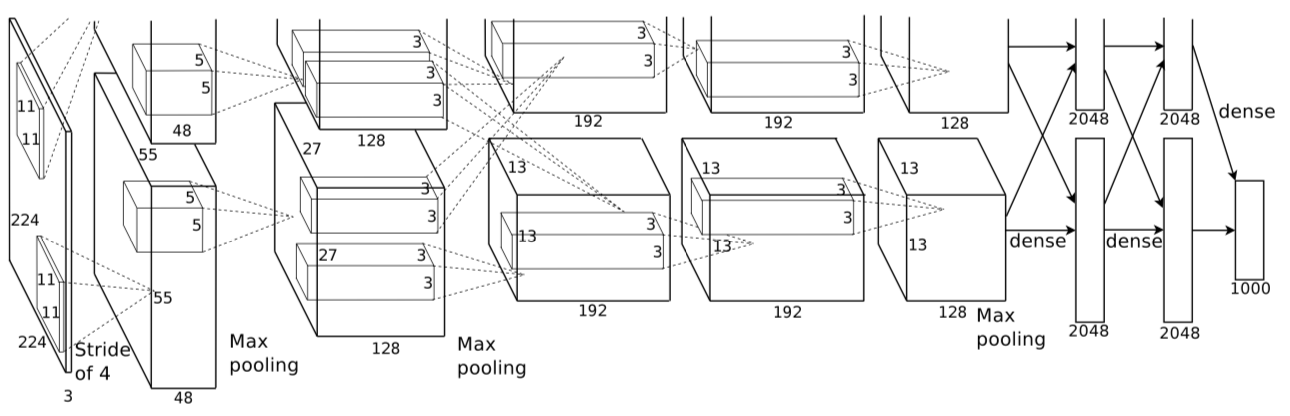

# TensorBoard

TensorBoard is an essential tool to monitor our model and the training.  Keras/TF will write a log after every epoch of the model and the current training metrics. All you need to do is type at the command line:

tensorboard --logdir='./logs'

And then open the browser to http://localhost:6006


In [8]:
tb_log = keras.callbacks.TensorBoard(
    log_dir="./logs",  # This is where the log files will go
    histogram_freq=10,
    write_graph=True,
    write_images=True,
)

In [9]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01
    ),
    metrics=[
        "accuracy",
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 12, 96)        2496      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 256)       221440    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 384)         885120    
_________________________________________________________________
ernie (Conv2D)               (None, 4, 4, 384)         1327488   
_________________________________________________________________
cookie (Conv2D)              (None, 2, 2, 256)         884992

In [11]:
%load_ext tensorboard
%tensorboard --logdir logs

In [12]:
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,  # 1=Show a progress bar
    validation_data=(x_test, y_test),
    callbacks=[tb_log],
)

Epoch 1/4
469/469 [==============================] - 29s 43ms/step - loss: 0.5955 - accuracy: 0.7918 - auc: 0.9553 - precision: 0.9066 - recall: 0.7374 - val_loss: 0.0338 - val_accuracy: 0.9892 - val_auc: 0.9997 - val_precision: 0.9907 - val_recall: 0.9881
Epoch 2/4
469/469 [==============================] - 10s 21ms/step - loss: 0.0364 - accuracy: 0.9896 - auc: 0.9995 - precision: 0.9904 - recall: 0.9883 - val_loss: 0.0260 - val_accuracy: 0.9924 - val_auc: 0.9997 - val_precision: 0.9930 - val_recall: 0.9918
Epoch 3/4
469/469 [==============================] - 10s 20ms/step - loss: 0.0184 - accuracy: 0.9947 - auc: 0.9998 - precision: 0.9952 - recall: 0.9941 - val_loss: 0.0219 - val_accuracy: 0.9927 - val_auc: 0.9998 - val_precision: 0.9933 - val_recall: 0.9921
Epoch 4/4
469/469 [==============================] - 9s 20ms/step - loss: 0.0132 - accuracy: 0.9961 - auc: 0.9999 - precision: 0.9965 - recall: 0.9957 - val_loss: 0.0231 - val_accuracy: 0.9934 - val_auc: 0.9995 - val_precision: 0

In [13]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test AUC:", score[2])
print("Test Precision:", score[3])
print("Test Recall:", score[4])

313/313 [==============================] - 5s 8ms/step - loss: 0.0231 - accuracy: 0.9934 - auc: 0.9995 - precision: 0.9939 - recall: 0.9931
Test loss: 0.023086508736014366
Test accuracy: 0.993399977684021
Test AUC: 0.9995113611221313
Test Precision: 0.9938951134681702
Test Recall: 0.9930999875068665


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Loss curves

It's always a good idea to look at the loss curves. They can tell you if your model is indeed "learning" and can point out when it over-fits the training set. TensorBoard is the better way to monitor this, but it can be done also manually with matplotlib.

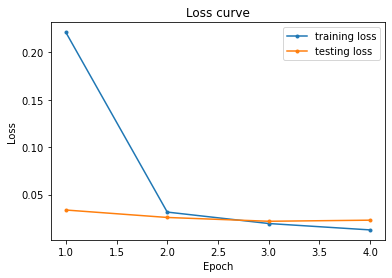

In [15]:
plt.plot(
    range(1, epochs + 1),
    history.history["loss"],
    ".-",
    range(1, epochs + 1),
    history.history["val_loss"],
    ".-",
)
plt.legend(["training loss", "testing loss"])
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Predictions

Now let's use the model to predict the test set images.

In [16]:
all_predictions = model.predict(x_test).argmax(axis=1)
print(all_predictions)

[7 2 1 ... 4 5 6]


In [17]:
import numpy as np

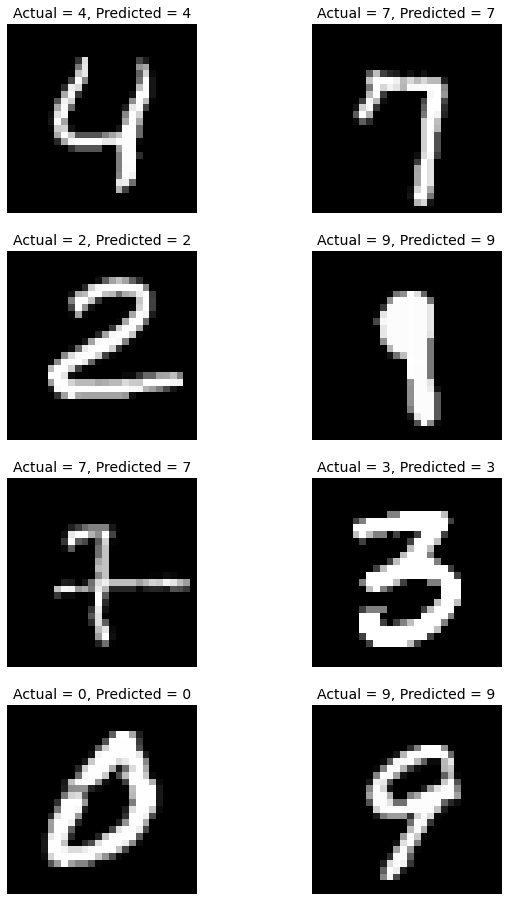

In [18]:
samples = [
    4,
    83,
    298,
    1045,
    3751,
    5555,
    7112,
    8953,
]  # Just print out some random examples from the test set

plt.subplots(len(samples) // 2, 2, figsize=(10, 16))

for i, n in enumerate(samples):

    img = np.expand_dims(
        x_test[n, :, :, :], 0
    )  # Numpy collapses the singleton dimension

    plt.subplot(len(samples) // 2, 2, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis("off")

    label = y_test[n].argmax()
    predicted_label = model.predict(img).argmax()  # Predict for just one image

    plt.title("Actual = {}, Predicted = {}".format(label, predicted_label), fontsize=14)

In [21]:
model.save("my_alexnet_model")
!ls my_alexnet_model

INFO:tensorflow:Assets written to: my_alexnet_model/assets
my_alexnet_model
├── assets
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 3 files
